In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
tf.random.set_seed(42)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-03-27 13:56:00.261781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 13:56:00.261903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 13:56:00.394145: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/bag-of-words-pretrain_model/keras/pretrain_model/1/pretrain_model.keras
/kaggle/input/word2vec-nlp-tutorial/sampleSubmission.csv
/kaggle/input/word2vec-nlp-tutorial/testData.tsv/testData.tsv
/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv/labeledTrainData.tsv
/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv/unlabeledTrainData.tsv


In [2]:
#Functions
def analyze(df):
    print(df.info(), df.describe(), "\n", df.shape, "\n")
    
import math
def prep_unsupervised_dataset(df):
    np.random.seed(42)
    sentences = []
    next_words = []
    for x in df.to_numpy():
#         print(x[0].replace("<br /><br />", " "))
#         x = x[0].replace("<br /><br />", " ").replace("\"", "").replace("(", "").replace(")", "").split()
        x = x[0].replace("<br /><br />", " ").split()
        sent_len = len(x) / 2
        start = np.random.randint(math.ceil(sent_len))
        sentences.append(" ".join(x[start:start+math.floor(sent_len)]))
        next_words.append(x[start+math.floor(sent_len)])
#     print(sentences)
#     print(next_words)
    return sentences, next_words

def create_dataset(X, y):
    return tf.data.Dataset.from_tensor_slices((X, y)).batch(32).prefetch(1)

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["train", "valid"])

In [3]:
#Prepare dataset
df_labeled = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv/labeledTrainData.tsv', sep="\t").drop('id', axis=1)
df_unlabeled = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv/unlabeledTrainData.tsv', sep="\t", on_bad_lines='warn').drop('id', axis=1)
X = df_labeled.copy()
y = X.pop('sentiment')

analyze(df_unlabeled)
analyze(X)
analyze(y)
y.value_counts()

/tmp/ipykernel_26/2639873999.py:3: ParserWarning: Skipping line 43043: expected 2 fields, saw 3

  df_unlabeled = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv/unlabeledTrainData.tsv', sep="\t", on_bad_lines='warn').drop('id', axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  49998 non-null  object
dtypes: object(1)
memory usage: 390.7+ KB
None                                                    review
count                                               49998
unique                                              49505
top     Am not from America, I usually watch this show...
freq                                                    5 
 (49998, 1) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  25000 non-null  object
dtypes: object(1)
memory usage: 195.4+ KB
None                                                    review
count                                               25000
unique                                              2

sentiment
1    12500
0    12500
Name: count, dtype: int64

In [4]:
#Prepare tf dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

train_set = create_dataset(X_train, y_train)
valid_set = create_dataset(X_valid, y_valid)

# for batch in train_set.take(1):
#     print(batch)

In [5]:
# import time

# t1 = time.time()

# text_vect_layer = tf.keras.layers.TextVectorization()
# text_vect_layer.adapt(tf.data.Dataset.from_tensor_slices(pd.concat([df_unlabeled, X_train]).review))
# # text_vect_layer.adapt(tf.data.Dataset.from_tensor_slices(X_train.review))

# t2 = time.time()

# print(vocab_size := text_vect_layer.vocabulary_size())
# print("time elapsed:", t2 - t1)

In [6]:
# X_unlabeled_train, X_unlabeled_valid, y_unlabeled_train, y_unlabeled_valid = train_test_split(*prep_unsupervised_dataset(pd.concat([df_unlabeled, X_train])), test_size=0.1, random_state=42)

# unlabeled_train_set = create_dataset(X_unlabeled_train, text_vect_layer(y_unlabeled_train))
# unlabeled_valid_set = create_dataset(X_unlabeled_valid, text_vect_layer(y_unlabeled_valid))

# # for batch in unlabeled_train_set.take(1):
# #     print(batch)

In [7]:
# #Unsupervised pretraining
# text_vect_layer.ragged = True
# embed_size = 256

# pretrain_model = tf.keras.Sequential([
#     text_vect_layer, 
#     tf.keras.layers.Embedding(vocab_size, embed_size), 
# #     tf.keras.layers.GRU(256, return_sequences=True), 
# #     tf.keras.layers.GRU(128, return_sequences=True), 
#     tf.keras.layers.GRU(256), 
# #     tf.keras.layers.Dropout(0.3), 
#     tf.keras.layers.Dense(vocab_size, activation='softmax')
# ])

# pretrain_model.build([None])
# pretrain_model.summary()

# pretrain_model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [8]:
# #Fit/Evaluate pretrained model
# history1 = pretrain_model.fit(unlabeled_train_set, validation_data=unlabeled_valid_set, epochs=20)

# plot_loss(history1)
# plt.title("pretrain_model learning curve")
# plt.show()

In [9]:
# pretrain_model.save('pretrain_model.keras')
# loaded_pretrain_model = tf.keras.models.load_model('pretrain_model.keras')
# loaded_pretrain_model.evaluate(unlabeled_train_set)

In [10]:
# history2 = pretrain_model.fit(unlabeled_train_set, validation_data=unlabeled_valid_set, epochs=10)

# plot_loss(history2)
# plt.title("pretrain_model learning curve")
# plt.show()

In [11]:
# pretrain_model.save('pretrain_model.keras')
# loaded_pretrain_model = tf.keras.models.load_model('pretrain_model.keras')
# loaded_pretrain_model.evaluate(unlabeled_train_set)

In [12]:
#Load pretrained model
import shutil
src_path = r"/kaggle/input/bag-of-words-pretrain_model/keras/pretrain_model/1/pretrain_model.keras"
tgt_path = r"/kaggle/working/"
shutil.copy(src_path, tgt_path)

loaded_pretrain_model = tf.keras.models.load_model('/kaggle/working/pretrain_model.keras')
# loaded_pretrain_model.evaluate(unlabeled_train_set)

In [13]:
#Build model
# pretrain_model = tf.keras.models.clone_model(loaded_pretrain_model)
# pretrain_model.set_weights(loaded_pretrain_model.get_weights())

model = tf.keras.Sequential(loaded_pretrain_model.layers[:2])
model.add(tf.keras.layers.Dropout(0.4))
model.add(loaded_pretrain_model.layers[2])
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l1'))

model.build([None])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 256)      │    59,772,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,168,449 (229.52 MB)

 Trainable params: 60,167,937 (229.52 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.4983 - loss: 0.9746 - val_accuracy: 0.5328 - val_loss: 0.7073
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5178 - loss: 0.7055 - val_accuracy: 0.5252 - val_loss: 0.7028
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.5194 - loss: 0.7041 - val_accuracy: 0.5368 - val_loss: 0.7010
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.5177 - loss: 0.7039 - val_accuracy: 0.5312 - val_loss: 0.7025
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5175 - loss: 0.7045 - val_accuracy: 0.5320 - val_loss: 0.7024
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5227 - loss: 0.7042 - val_accuracy: 0.5372 - val_loss: 0.7005
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5277 - loss: 0.7030 - val_accuracy: 0.5196 - val_loss: 0.7031
Epoch 8/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5238 - loss: 0.7028 - 

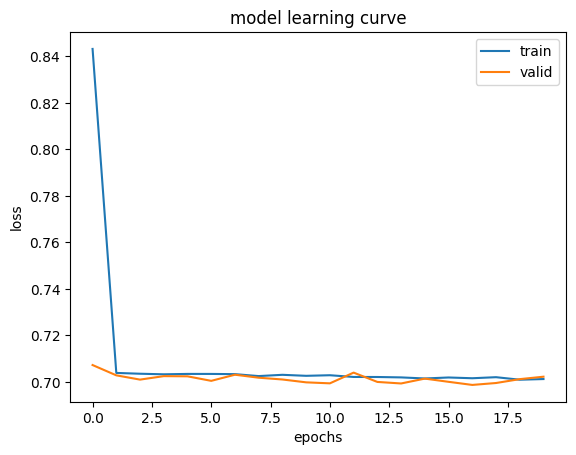

In [14]:
#Fit/Evaluate model
for layer in model.layers[:-3]:
    layer.trainable = False
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history3 = model.fit(train_set, validation_data=valid_set, epochs=20, callbacks=[early_stopping])

plot_loss(history3)
plt.title("model learning curve")
plt.show()

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 53s 72ms/step - accuracy: 0.5489 - loss: 0.6962 - val_accuracy: 0.6584 - val_loss: 0.6346
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step - accuracy: 0.7105 - loss: 0.5805 - val_accuracy: 0.7840 - val_loss: 0.4895
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step - accuracy: 0.8354 - loss: 0.4073 - val_accuracy: 0.8304 - val_loss: 0.4224
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step - accuracy: 0.8866 - loss: 0.3186 - val_accuracy: 0.8480 - val_loss: 0.4270
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step - accuracy: 0.9206 - loss: 0.2409 - val_accuracy: 0.8440 - val_loss: 0.4086
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step - accuracy: 0.9458 - loss: 0.1870 - val_accuracy: 0.8600 - val_loss: 0.4271
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 50s 70ms/step - accuracy: 0.9645 - loss: 0.1412 - val_accuracy: 0.8648 - val_loss: 0.4421
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 49s 70ms/step - accuracy: 0.9713 - loss: 0.1204 - 

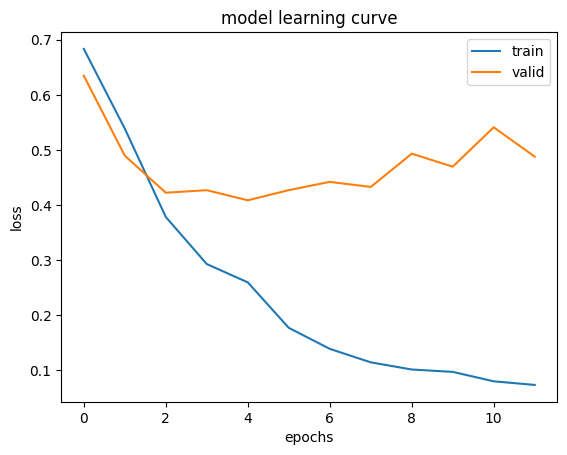

In [15]:
for layer in model.layers[:-3]:
    layer.trainable = True
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history4 = model.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[early_stopping])

plot_loss(history4)
plt.title("model learning curve")
plt.show()

In [16]:
# model_ = tf.keras.Sequential([
#     text_vect_layer, 
#     tf.keras.layers.Embedding(vocab_size, 128), 
# #     tf.keras.layers.GRU(256, return_sequences=True), 
# #     tf.keras.layers.GRU(128, return_sequences=True), 
#     tf.keras.layers.GRU(128), 
# #     tf.keras.layers.Dropout(0.3), 
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# model_.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
# history5 = model_.fit(train_set, validation_data=valid_set, epochs=10)

# plot_loss(history5)
# plt.title("model learning curve")
# plt.show()
# #0.999 0.006 0.860 0.770

In [17]:
model.fit(train_set.concatenate(valid_set), epochs=1)
model.evaluate(train_set.concatenate(valid_set))

783/783 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.9721 - loss: 0.1213
783/783 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.9807 - loss: 0.1617


[0.16860546171665192, 0.9771199822425842]

In [18]:
#Prepare test set
X_test = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/testData.tsv/testData.tsv', sep="\t")
analyze(X_test)

test_set = tf.data.Dataset.from_tensor_slices(X_test.review).batch(32).prefetch(1)
# for batch in test_set.take(1):
#     print(batch)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   review  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB
None               id                                             review
count      25000                                              25000
unique     25000                                              24801
top     11465_10  Loved today's show!!! It was a variety and not...
freq           1                                                  5 
 (25000, 2) 



In [19]:
#Make predictions
predictions = model.predict(test_set)
predictions = list(map(lambda x: 1 if x > 0.5 else 0, predictions))
for x in predictions[:5]:
    print(x)

sample = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/sampleSubmission.csv')
submission = pd.DataFrame({"id": sample.id, "sentiment": predictions})
submission.to_csv('submission.csv', index=False)
pd.read_csv('/kaggle/working/submission.csv')

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step
1
0
1
0
1


,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1
...,...,...
24995,2155_10,0
24996,59_10,1
24997,2531_1,0
24998,7772_8,1
